In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

<IPython.core.display.Javascript object>

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')==3:
        temp_id = '.'.join(temp_id.split('.')[0:-1])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')
        
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [3]:
#add back the description of the proteins
desc_dict = {}
path = 'TriTrypDB-32_TbruceiTREU927_AnnotatedProteins.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc

In [4]:
#read data and log transform for plots
df = pd.read_csv('proteinGroups.txt',sep='\t')
df = clean(df)
df.head()
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df['logInt']=np.log10(df['Intensity'])
df['logRatio']=np.log2(df['Ratio H/L normalized'])
df['logScore']=np.log10(df['Score'])

removed  52 Only identified by site
tot  52  entries removed
---------------
removed  20 Reverse
tot  72  entries removed
---------------
removed  29 Potential contaminant
tot  101  entries removed
---------------


In [5]:
#get transmembrane and peptide signal from TryTripDB
tm = pd.read_csv('GeneByLocusTag_Summary.txt',sep='\t')
tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
tm.set_index('[Input ID]',inplace=True)

df['[Input ID]'] = df['Gene_id']
df.set_index('[Input ID]',inplace=True)
df = df.join(tm, how='left')
df['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df['[SignalP Peptide]'] ] 



In [6]:
#add number of unique peptide identified
df['unique'] = [int(n.split(';')[0]) for n in df['Peptide counts (unique)']]

In [7]:
#select some fielsd from the full output
selection = df[['Gene_desc', 'unique','Score', 
                'Ratio H/L normalized', 'Intensity', 
                'logInt', 'logRatio','logScore', '[SignalP Peptide]','[# TM Domains]']]
selection.dropna(inplace=True)
selection.sort_values('logRatio',inplace=True,ascending =False)
selection.head()

,Gene_desc,unique,Score,Ratio H/L normalized,Intensity,logInt,logRatio,logScore,[SignalP Peptide],[# TM Domains]
[Input ID],,,,,,,,,,
Tb927.11.9400,"hypothetical protein, conserved",4,4.7487,21.2700,1061800,6.026043,4.410748,0.676575,0,0.0
Tb927.5.1210,"short-chain dehydrogenase, putative",6,102.8800,13.6010,47788000,7.679319,3.765641,2.012331,1,2.0
Tb927.11.12080,N-acetyl-D-glucosaminylphosphatidylinositol de...,2,29.8040,13.2970,3156700,6.499233,3.733029,1.474275,0,0.0
Tb927.11.6210,Lanosterol 14-alpha demethylase,4,4.3205,12.7250,4638000,6.666331,3.669594,0.635534,1,0.0
Tb927.10.4040,3-keto-dihydrosphingosine reductase,4,6.3210,9.7405,1800500,6.255393,3.283996,0.800786,1,1.0


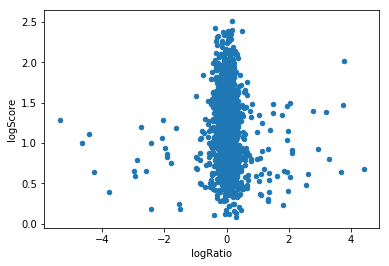

In [8]:
#basic plot
fig,ax = plt.subplots()
selection.plot(kind='scatter', y='logScore',x='logRatio', ax=ax)
fig.savefig('test.png')

In [9]:
[selection.logRatio.loc['Tb927.11.12080']]

[3.733028883972776]

In [32]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logRatio,
    y=selection.logInt,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(selection.index.values, selection.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = selection.logRatio, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logRatio.loc['Tb927.11.12080']],
    y=[selection.logInt.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Bait',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='MA')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')